In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from functools import reduce

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [ ]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
file_path = 'data_input_auto/独立炼厂库存.xlsx'
sheet = pd.ExcelFile(file_path).parse('Sheet1')
sheet.rename(columns={'DataTime': 'Date'}, inplace=True)
sheet['Date'] = pd.to_datetime(sheet['Date'], errors='coerce')
sheet.tail()

,Date,中国独立炼厂汽油产量(预测/最新),中国独立炼厂汽油库存
268,2025-06-27,83.34,NaN
269,2025-07-04,83.34,NaN
270,2025-07-11,83.34,NaN
271,2025-07-18,83.34,NaN
272,2025-07-25,83.34,NaN


In [4]:
file_path1 = 'data_output_auto/中国独立炼厂汽油表需.xlsx'
sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
sheet1.rename(columns={'DataTime': 'Date'}, inplace=True)
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1.tail()

,Date,中国独立炼厂汽油表需
23,2025-05-26,85.552650
24,2025-05-27,85.381416
25,2025-05-28,85.372482
26,2025-05-29,85.749008
27,2025-05-30,85.749008


In [5]:
sheet['Date'] = pd.to_datetime(sheet['Date'])
date_range = pd.date_range(start=sheet['Date'].min(), end=sheet['Date'].max(), freq='D')
daily_df = pd.DataFrame({'Date': date_range})

# 与原始数据合并,保留Date和中国独立炼厂汽油产量(预测/最新)列
sheet_daily = pd.merge(daily_df, sheet[['Date', '中国独立炼厂汽油产量(预测/最新)']], on='Date', how='left')

# 对中国独立炼厂汽油产量(预测/最新)进行线性插值填充
sheet_daily['中国独立炼厂汽油产量(预测/最新)'] = sheet_daily['中国独立炼厂汽油产量(预测/最新)'].interpolate(method='linear')

# 使用填充后的数据进行合并
merged_df = pd.merge(sheet1, sheet_daily, on='Date', how='left')

# 计算中国独立炼厂汽油库存
merged_df['中国独立炼厂汽油库存_环差'] = merged_df['中国独立炼厂汽油产量(预测/最新)'] - merged_df['中国独立炼厂汽油表需']

In [6]:
merged_df.head()

,Date,中国独立炼厂汽油表需,中国独立炼厂汽油产量(预测/最新),中国独立炼厂汽油库存_环差
0,2025-05-03,87.645912,83.34,-4.305912
1,2025-05-04,87.030319,83.34,-3.690319
2,2025-05-05,86.534142,83.34,-3.194142
3,2025-05-06,85.599167,83.34,-2.259167
4,2025-05-07,85.374474,83.34,-2.034474


In [7]:
'''
# 获取sheet中最后一个有效的中国独立炼厂汽油库存值
last_valid_inventory = sheet.loc[sheet['中国独立炼厂汽油库存'].last_valid_index(), '中国独立炼厂汽油库存']

# 初始化中国独立炼厂汽油库存列
merged_df['中国独立炼厂汽油库存'] = None

# 计算第一个库存值
merged_df.iloc[0, merged_df.columns.get_loc('中国独立炼厂汽油库存')] = last_valid_inventory + merged_df.iloc[0]['中国独立炼厂汽油库存_环差']

# 循环计算后续库存值
for i in range(1, len(merged_df)):
    merged_df.iloc[i, merged_df.columns.get_loc('中国独立炼厂汽油库存')] = (
        merged_df.iloc[i-1]['中国独立炼厂汽油库存'] + 
        merged_df.iloc[i]['中国独立炼厂汽油库存_环差']
    )
merged_df.head()
'''

"\n# 获取sheet中最后一个有效的中国独立炼厂汽油库存值\nlast_valid_inventory = sheet.loc[sheet['中国独立炼厂汽油库存'].last_valid_index(), '中国独立炼厂汽油库存']\n\n# 初始化中国独立炼厂汽油库存列\nmerged_df['中国独立炼厂汽油库存'] = None\n\n# 计算第一个库存值\nmerged_df.iloc[0, merged_df.columns.get_loc('中国独立炼厂汽油库存')] = last_valid_inventory + merged_df.iloc[0]['中国独立炼厂汽油库存_环差']\n\n# 循环计算后续库存值\nfor i in range(1, len(merged_df)):\n    merged_df.iloc[i, merged_df.columns.get_loc('中国独立炼厂汽油库存')] = (\n        merged_df.iloc[i-1]['中国独立炼厂汽油库存'] + \n        merged_df.iloc[i]['中国独立炼厂汽油库存_环差']\n    )\nmerged_df.head()\n"

In [8]:
# 计算中国独立炼厂汽油库存,基准值设为86
merged_df['中国独立炼厂汽油库存'] = 86 + merged_df['中国独立炼厂汽油库存_环差']
merged_df.head()

,Date,中国独立炼厂汽油表需,中国独立炼厂汽油产量(预测/最新),中国独立炼厂汽油库存_环差,中国独立炼厂汽油库存
0,2025-05-03,87.645912,83.34,-4.305912,81.694088
1,2025-05-04,87.030319,83.34,-3.690319,82.309681
2,2025-05-05,86.534142,83.34,-3.194142,82.805858
3,2025-05-06,85.599167,83.34,-2.259167,83.740833
4,2025-05-07,85.374474,83.34,-2.034474,83.965526


In [9]:
# 提取中国独立炼厂汽油库存数据
库存_df = merged_df[['Date', '中国独立炼厂汽油库存']]

库存_df.to_excel('data_output_auto/中国独立炼厂汽油库存预测.xlsx', index=False)
print('中国独立炼厂汽油库存预测数据已保存')

中国独立炼厂汽油库存预测数据已保存


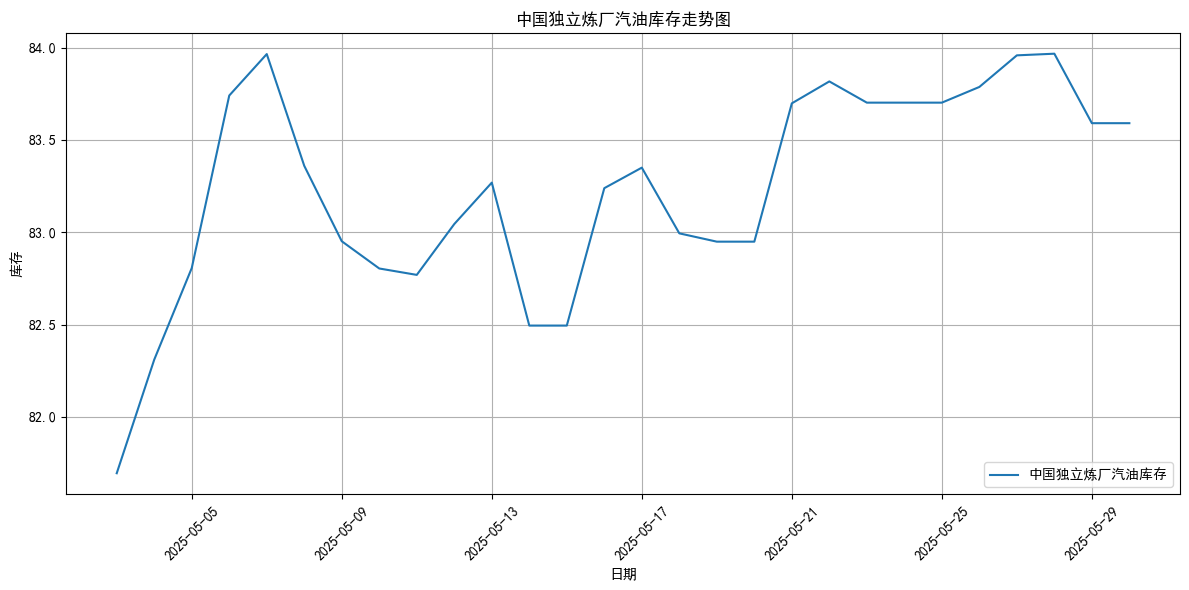

In [10]:
# 绘制库存数据图表
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(库存_df['Date'], 库存_df['中国独立炼厂汽油库存'], '-', label='中国独立炼厂汽油库存')
plt.grid(True)
plt.title('中国独立炼厂汽油库存走势图')
plt.xlabel('日期')
plt.ylabel('库存')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


---

In [11]:
sheet

,Date,中国独立炼厂汽油产量(预测/最新),中国独立炼厂汽油库存
0,2020-05-08,107.74,108.60
1,2020-05-15,106.00,104.71
2,2020-05-22,108.79,100.00
3,2020-05-29,111.10,90.20
4,2020-06-05,115.24,94.30
...,...,...,...
268,2025-06-27,83.34,NaN
269,2025-07-04,83.34,NaN
270,2025-07-11,83.34,NaN
271,2025-07-18,83.34,NaN


In [12]:
sheet_kucun = sheet[['Date','中国独立炼厂汽油库存']].copy()
# 将历史数据和预测数据合并
库存_df_weekly = 库存_df.resample('W-MON', on='Date').mean()
sheet_kucun = pd.merge(sheet_kucun, 库存_df_weekly, on='Date', how='outer')

In [13]:
# 重命名列
sheet_kucun = sheet_kucun.rename(columns={
    '中国独立炼厂汽油库存_x': '中国独立炼厂汽油库存',
    '中国独立炼厂汽油库存_y': '中国独立炼厂汽油库存_预测'
})

# 删除两列都为空的行
sheet_kucun = sheet_kucun.dropna(subset=['中国独立炼厂汽油库存', '中国独立炼厂汽油库存_预测'], how='all')

sheet_kucun

,Date,中国独立炼厂汽油库存,中国独立炼厂汽油库存_预测
0,2020-05-08,108.60,NaN
1,2020-05-15,104.71,NaN
2,2020-05-22,100.00,NaN
3,2020-05-29,90.20,NaN
4,2020-06-05,94.30,NaN
...,...,...,...
261,2025-05-05,NaN,82.269876
263,2025-05-12,NaN,83.233476
265,2025-05-19,NaN,82.969877
267,2025-05-26,NaN,83.622705


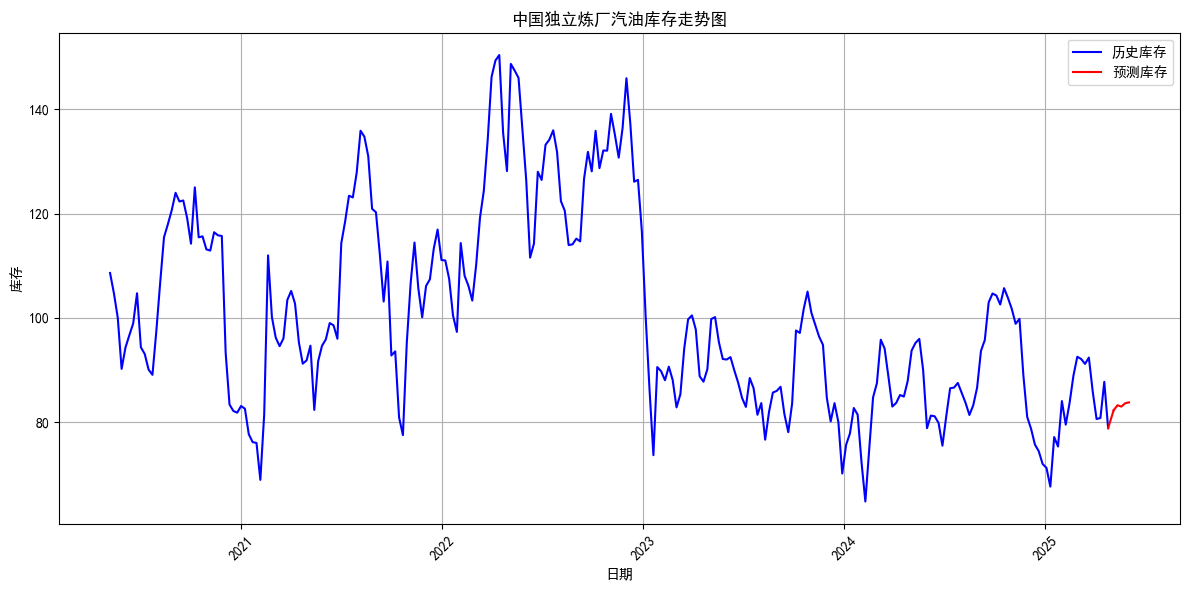

In [14]:
# 绘制库存数据图表
plt.figure(figsize=(12, 6))

# 获取历史库存最后一个非空值和预测库存第一个非空值
last_hist = sheet_kucun[sheet_kucun['中国独立炼厂汽油库存'].notna()]['中国独立炼厂汽油库存'].iloc[-1]
first_pred = sheet_kucun[sheet_kucun['中国独立炼厂汽油库存_预测'].notna()]['中国独立炼厂汽油库存_预测'].iloc[0]

# 获取对应的日期
last_hist_date = sheet_kucun[sheet_kucun['中国独立炼厂汽油库存'].notna()]['Date'].iloc[-1]
first_pred_date = sheet_kucun[sheet_kucun['中国独立炼厂汽油库存_预测'].notna()]['Date'].iloc[0]

# 绘制主要数据
plt.plot(sheet_kucun['Date'], sheet_kucun['中国独立炼厂汽油库存'], '-', label='历史库存', color='blue')
plt.plot(sheet_kucun['Date'], sheet_kucun['中国独立炼厂汽油库存_预测'], '-', label='预测库存', color='red')

# 绘制连接线
plt.plot([last_hist_date, first_pred_date], [last_hist, first_pred], '-', color='red')

plt.grid(True)
plt.title('中国独立炼厂汽油库存走势图')
plt.xlabel('日期')
plt.ylabel('库存')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
merged_df_daily = sheet_kucun.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/汽油独立炼厂库存_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_daily.head()

,Date,中国独立炼厂汽油库存,中国独立炼厂汽油库存_预测
269,2025/06/02,NaN,83.777021
267,2025/05/26,NaN,83.622705
265,2025/05/19,NaN,82.969877
263,2025/05/12,NaN,83.233476
261,2025/05/05,NaN,82.269876


In [16]:
merged_df_monthly = sheet_kucun.resample('ME', on='Date').last().reset_index()
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/汽油独立炼厂库存_月度数据.xlsx', index=False, float_format='%.2f')
merged_df_monthly.head()

,Date,中国独立炼厂汽油库存,中国独立炼厂汽油库存_预测
61,2025/06/30,NaN,83.777021
60,2025/05/31,NaN,83.622705
59,2025/04/30,78.8272,NaN
58,2025/03/31,85.8672,NaN
57,2025/02/28,92.5280,NaN


In [17]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "中国独立炼厂汽油库存"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [18]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "中国独立炼厂汽油库存"
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/04/30)
数据已成功更新到Excel文件
